# SARIMA MODELS

In this notebook, we are going to fit a SARIMA MODEL by using the dataset without COVID data.

It is said that ${X_t}$ follows a multiplicative seasonal *ARIMA* model (*SARIMA*), and we denote it by: $ \{X_t\} \sim ARIMA(P,D,Q)_s\times(p,d,q)$, if:


$$\Phi_P(B^s) \phi_p(B) \nabla^D_s \nabla^d X_t = \theta_q(B) \Theta_Q(B^s) Y_t,$$

where:

* $ \{Y_t\} \sim WN(0, \sigma^2)$ is a white noise process.
* $\nabla^D_s = (1 - B^s)^D$ represents the seasonal differences.
* $\nabla^d = (1 - B)^d$ represents the regular differences.
* $\Phi_P(B^s) = 1 - \Phi_1 B^s - \dots - \Phi_P B^{sP}$  is the seasonal AR operator.
* $\phi_p(B) = 1 - \phi_1 B - \dots - \phi_p B^p$ is the regular AR operator.
* $\Theta_Q(B^s) = 1 - \Theta_1 B^s - \dots - \Theta_Q B^{sQ}$ is the seasonal MA operator.
* $\theta_q(B) = 1 - \theta_1 B - \dots - \theta_q B^q$  is the regular MA operator.


## 📑 Index  
* [1. EXPLORATORY PLOTS](#expl)
* [2. TRANSFORMATIONS TO GET A STATIONARY TIME SERIES](#trans)
* [3. IDENTIFYING THE *ARMA* STRUCTURE $(p, q, P, Q)$](#id)
* [4. MODEL SELECTION](#sel)
* [5. MODEL FIT AND PREDICTION. FINAL ERRORS TEST](#fit)

In [ ]:
'''
%time
'''
#lo he puesto en requirements, así que quitar luego

'\n%time\n'

We import the packages.

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pmdarima import auto_arima
import scipy.stats as sc 

import matplotlib.pyplot as plt

import statsmodels
import statsmodels.tsa.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn import metrics

from pathlib import Path
import joblib 

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')

ModuleNotFoundError: No module named 'pmdarima'

We load the data and consider that our data set goes from 2003 to 2019 (without COVID).

In [3]:
df = pd.read_csv("C:/Users/Juanfran cd/Desktop/MATEMATICAS UA/TFG/air traffic.csv", encoding="ISO-8859-1")

# Clean and convert 'Pax' to number
df['Pax'] = df['Pax'].str.replace(',', '', regex=True).astype(float)

# Create date column in YYYY-MM format
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2), format='%Y-%m')

# Filter data between 2003 and 2019 and select relevant columns
df1 = df.loc[df['Year'].between(2003, 2019), ['Date', 'Pax']].copy()

We split our data set into 2: a training set (from 2003 to 2017) and a test set (from 2018 to 2019).

In [4]:
train = df1.loc[df1['Date'] <= '2017-12-01']
test = df1.loc[df1['Date'] >= '2018-01-01']

<a id='expl'></a>
## 1. EXPLORATORY PLOTS

Plot of the original time series.

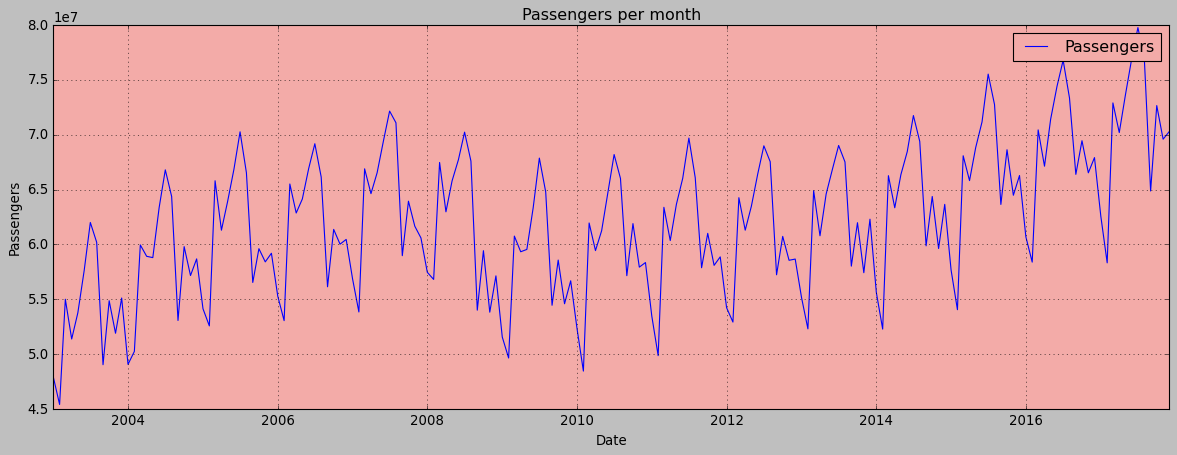

In [5]:
plt.style.use('classic')
dark_style = {
    'axes.facecolor':'#f3aba8'}
plt.rcParams.update(dark_style)

plt.figure(figsize=(18, 6))
sns.lineplot(x='Date', y='Pax', data=train, label = 'Passengers')
plt.title('Passengers per month')
plt.ylabel('Passengers')
plt.legend()
plt.grid()
plt.show()

Seasonal plot

In [6]:
def SEASONAL_PLOT(series, freq, title="Seasonal Plot"):
   
    series.index = pd.to_datetime(series.index)

    df = series.copy()
    df = df.rename(columns={df.columns[0]: "value"})

    df["year"] = df.index.year
    df["season"] = df.index.month if freq == 12 else df.index.dayofyear

    plt.figure(figsize=(10, 6))
    sns.lineplot(x="season", y="value", hue="year", data=df, palette="tab10", marker="o")

    plt.title(title)
    plt.xlabel("Mes" if freq == 12 else "Período Estacional")
    plt.ylabel("Valor")
    plt.legend(title="Año", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

C:\Users\Juanfran cd\AppData\Local\Temp\ipykernel_18212\4290599651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Date"] = pd.to_datetime(train["Date"])


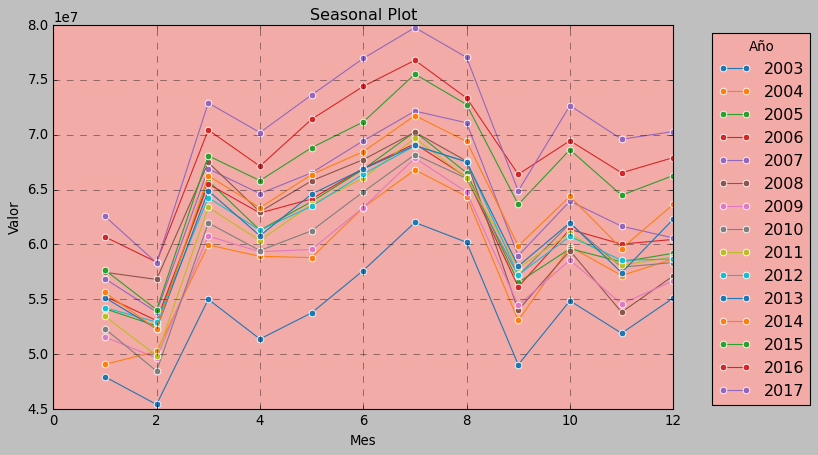

In [7]:
# Make sure 'Date' is datetime type and set it as index
train["Date"] = pd.to_datetime(train["Date"])
train = train.set_index("Date")

SEASONAL_PLOT(train, freq=12) 

Plor var function: this plot shows the relationship between the logarithm of the mean and the logarithm of the standard deviation.

In [8]:
def PLOT_VAR(x, n_tilde):

    x = np.array(x)
    
    m = len(x) // n_tilde  
    x = x[:m * n_tilde]    
    
    A_temp = x.reshape(m, n_tilde)
    
    xbar_vec = A_temp.mean(axis=1) 
    s_vec = A_temp.std(axis=1, ddof=1) 

    plt.figure(figsize=(8,6))
    plt.scatter(np.log(xbar_vec), np.log(s_vec), marker="o", color="blue")
    plt.xlabel("log(mean)")
    plt.ylabel("log(standard deviation)")
    plt.title(f"Number of observations per group: {n_tilde}")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

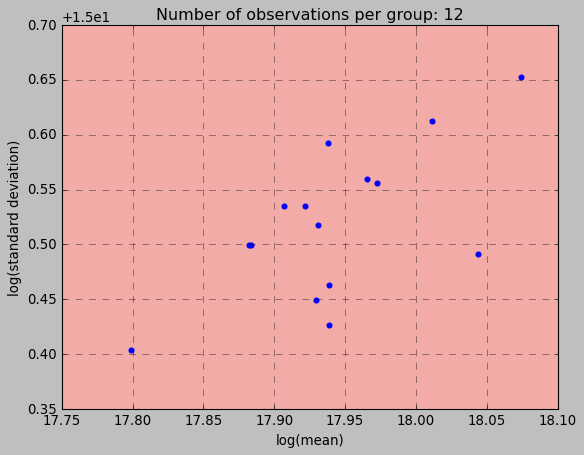

In [9]:
PLOT_VAR(train, 12)

After observing those plots, the suggest:
* That the mean is not constant over time since:
   - The presence of a trend component, because the number of passengers grows throughout the years.
   - The presence of a seasonal component with period s=12.
* How the variance is also not constant, because it increases as the series progresses.

Thus, we can say that the series is not stationary.

<a id='trans'></a>
## 2. TRANSFORMATIONS TO GET A STATIONARY TIME SERIES

As we have concluded that our dataset is not a stationary, let's apply two tranformationst o make our series stationary:
* A variance stabilizing transformations: $\hat{X}_t = g(X_t)$
* A mean stabilizing transformations: $W_t = ∇_{s}^D ∇^d \hat{X}_t$

 Let’s start with the variance stabilizing transformation.

### 2.1 Variance stabilizing transformations

As we have seen in the previous point,the relationship between the logarithm of the mean and the logarithm of the standard deviationfor our data (that has 12 observations per group) is approximately linear, so we can apply a Box-Cox transformation.

In [10]:
def INV_BOXCOX(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

In [11]:
X = sc.boxcox(train['Pax'])
l = X[1]
print('lambda = ', l)

lambda =  0.8635245594541531


In [12]:
X = pd.DataFrame(X[0], index = train.index, columns = ['Pax'])
X

,Pax
Date,
2003-01-01,4.968018e+06
2003-02-01,4.741124e+06
2003-03-01,5.594064e+06
2003-04-01,5.274434e+06
2003-05-01,5.485155e+06
...,...
2017-08-01,7.484022e+06
2017-09-01,6.450916e+06
2017-10-01,7.114147e+06


Transformed series obtained using Box-Cox transformation with lambda=0.86

<Figure size 960x480 with 0 Axes>

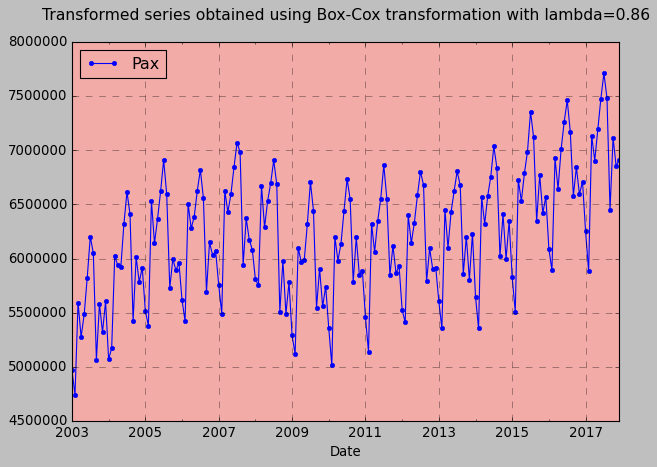

In [13]:
plt.figure(figsize=(12, 6))
X.plot(marker='.', markersize=8, linestyle='-')  
plt.title('Transformed series obtained using Box-Cox transformation with lambda=0.86', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.6) 
plt.tight_layout()  
plt.show()

### 2.2 Mean stabilizing transformations

Once we have stabilized the variance, we have to stabilize the mean by following two steps:
 1. Removing the trend component.
 2. Removing the seasonal component.

#### 2.2.1 Trend component (determining $d$)

In the transformed series plot, we can notice the presence of a linear trend component. Then, we have to apply the regular differencing operator $∇^d = (1 − B)^d$, with $d≥1$ in order to remove this trend.

We start checking the results of the Aumented Dickey-Fuller test, where the null hypothesis is:

$$ H_{0}: X_{t} \quad \text{is not stationary}$$

In [ ]:
def AUGMENTED_DICKEY_FULLER_TEST_FUNC(series, column_name):
    print(f'Dickey-Fuller test results for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusions:")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusions")
        print("Do not reject the null hypothesis")
        print("The data is not stationary")

In [15]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(X['Pax'], 'Pax')

Dickey-Fuller test results for column: Pax
Test Statistic                  -1.056471
p-value                          0.732115
No Lags Used                    13.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64
Conclusions
Do not reject the null hypothesis
The data not is stationary


According to the Dickey-Fuller test, the time series is not stationary because the p-value is greater than $0.05$. Then, let's apply the regular differencing operator once.

$$W_{t} = ∇X_{t} = X_{t} - X_{t-1}$$

In [16]:
W = (X - X.shift(1)).dropna()

In [17]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(W['Pax'], 'Pax')

Dickey-Fuller test results for column: Pax
Test Statistic                  -2.342865
p-value                          0.158516
No Lags Used                    12.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64
Conclusions
Do not reject the null hypothesis
The data not is stationary


The time series is still not stationary because the p-value is greater than $0.05$, so let's apply the regular differencing operator once again.

$$W1_{t} = ∇W_{t} = W_{t} - W_{t-1} = (1-B)^2X_{t} = (1−2B+B^2)X_{t} = X_{t} - 2X_{t-1} + X_{t-2}$$

In [18]:
W1 = (W - W.shift(1)).dropna()

Dickey-Fuller test results for column: Pax
Test Statistic                -5.810971e+00
p-value                        4.402389e-07
No Lags Used                   1.400000e+01
Number of Observations Used    1.630000e+02
Critical Value (1%)           -3.471119e+00
Critical Value (5%)           -2.879441e+00
Critical Value (10%)          -2.576314e+00
dtype: float64
Conclusions:
Reject the null hypothesis
The data is stationary


<Axes: xlabel='Date'>

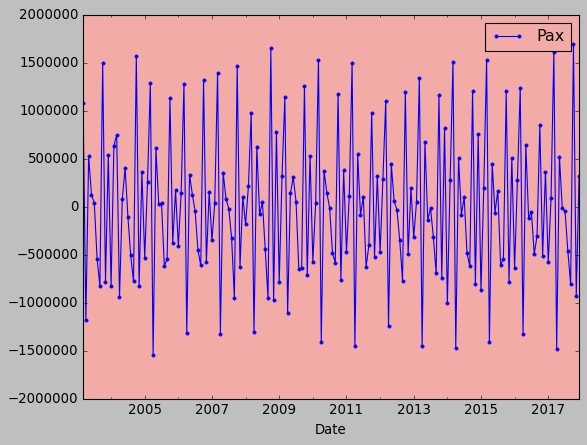

In [19]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(W1['Pax'], 'Pax')
W1.plot(marker='.')

According to the Dickey-Fuller test, the time series stationary because the p-value is not greater than $0.05$ and if we look at that plot, we can see that we have removed the trend component. Hence, we choose $d=2$.

#### 2.2.2 Seasonal component (determining $D$)

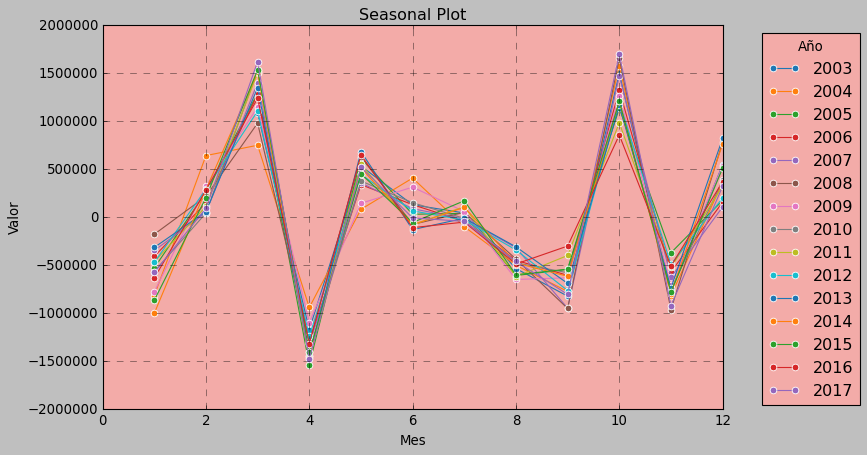

In [20]:
SEASONAL_PLOT(W1, freq=12)

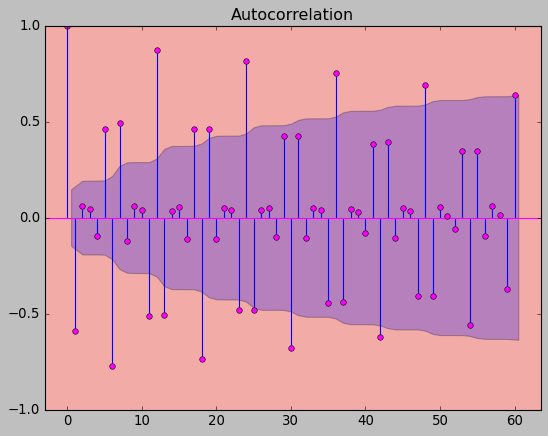

In [21]:
plot_acf(W1['Pax'], lags=60, color='fuchsia')
plt.show()

As we can see in the seasonal plot, the same pattern is repeated every s=12, that is, every year. In addition, the ACF of the series ${W1_𝑡}$ follows trend everys=12 and slowly decreases overtime.

Then, we have to apply the seasonal difference operator $∇_{12}=(1−𝐵^{12})$ to remove the seasonal component.

$$W2_{t} = ∇_{12}W1_{𝑡}$$

In [22]:
W2 = (W1- W1.shift(12)).dropna()

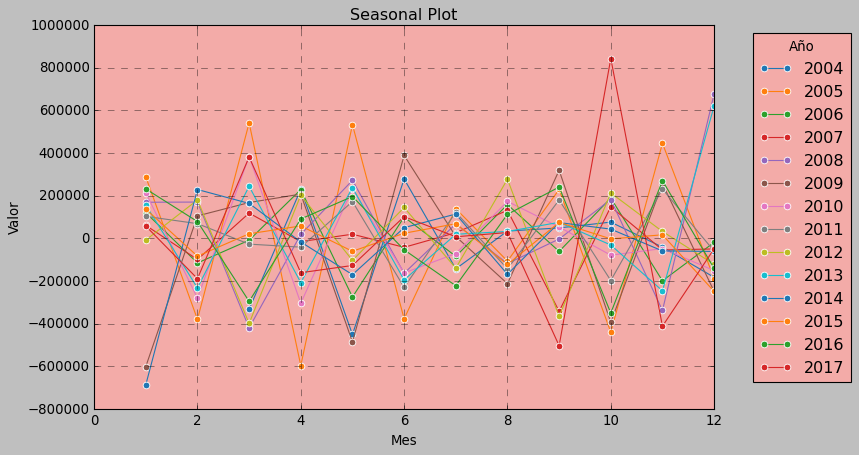

In [23]:
SEASONAL_PLOT(W2, freq=12)

Dickey-Fuller test results for column: Pax
Test Statistic                  -4.535711
p-value                          0.000169
No Lags Used                    12.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64
Conclusions:
Reject the null hypothesis
The data is stationary


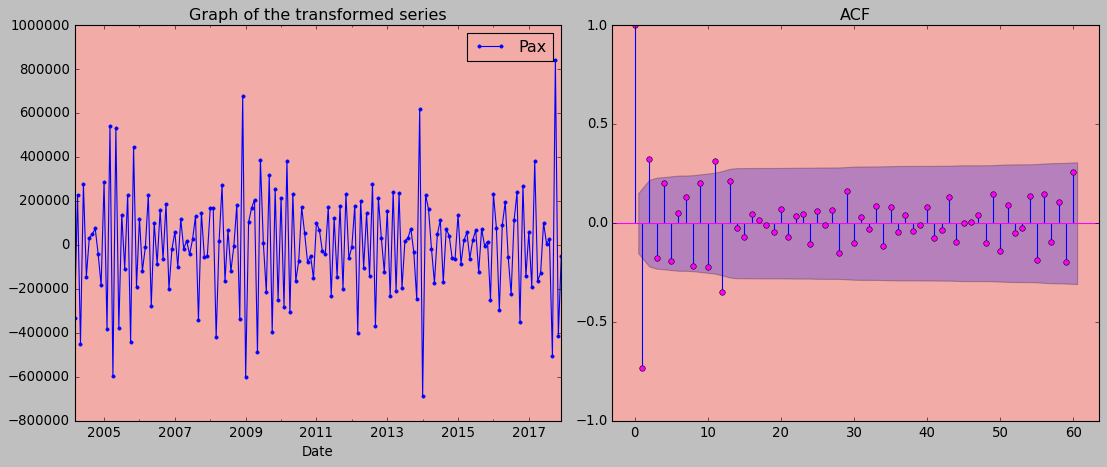

In [24]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(W2['Pax'], 'Pax')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

W2.plot(marker='.', ax=axes[0])  
axes[0].set_title("Graph of the transformed series")

plot_acf(W2['Pax'], lags=60, color='fuchsia', ax=axes[1])
axes[1].set_title("ACF")

plt.tight_layout()
plt.show()


We notice that according to the according to the Dickey-Fuller test, the time series is still stationary and the graph and the ACF of the transformed series do not show obvious deviations from stationarity.

Hence, we set the value $D=1$.

<a id='id'></a>
## 3. IDENTIFYING THE *ARMA* STRUCTURE $(p, q, P, Q)$

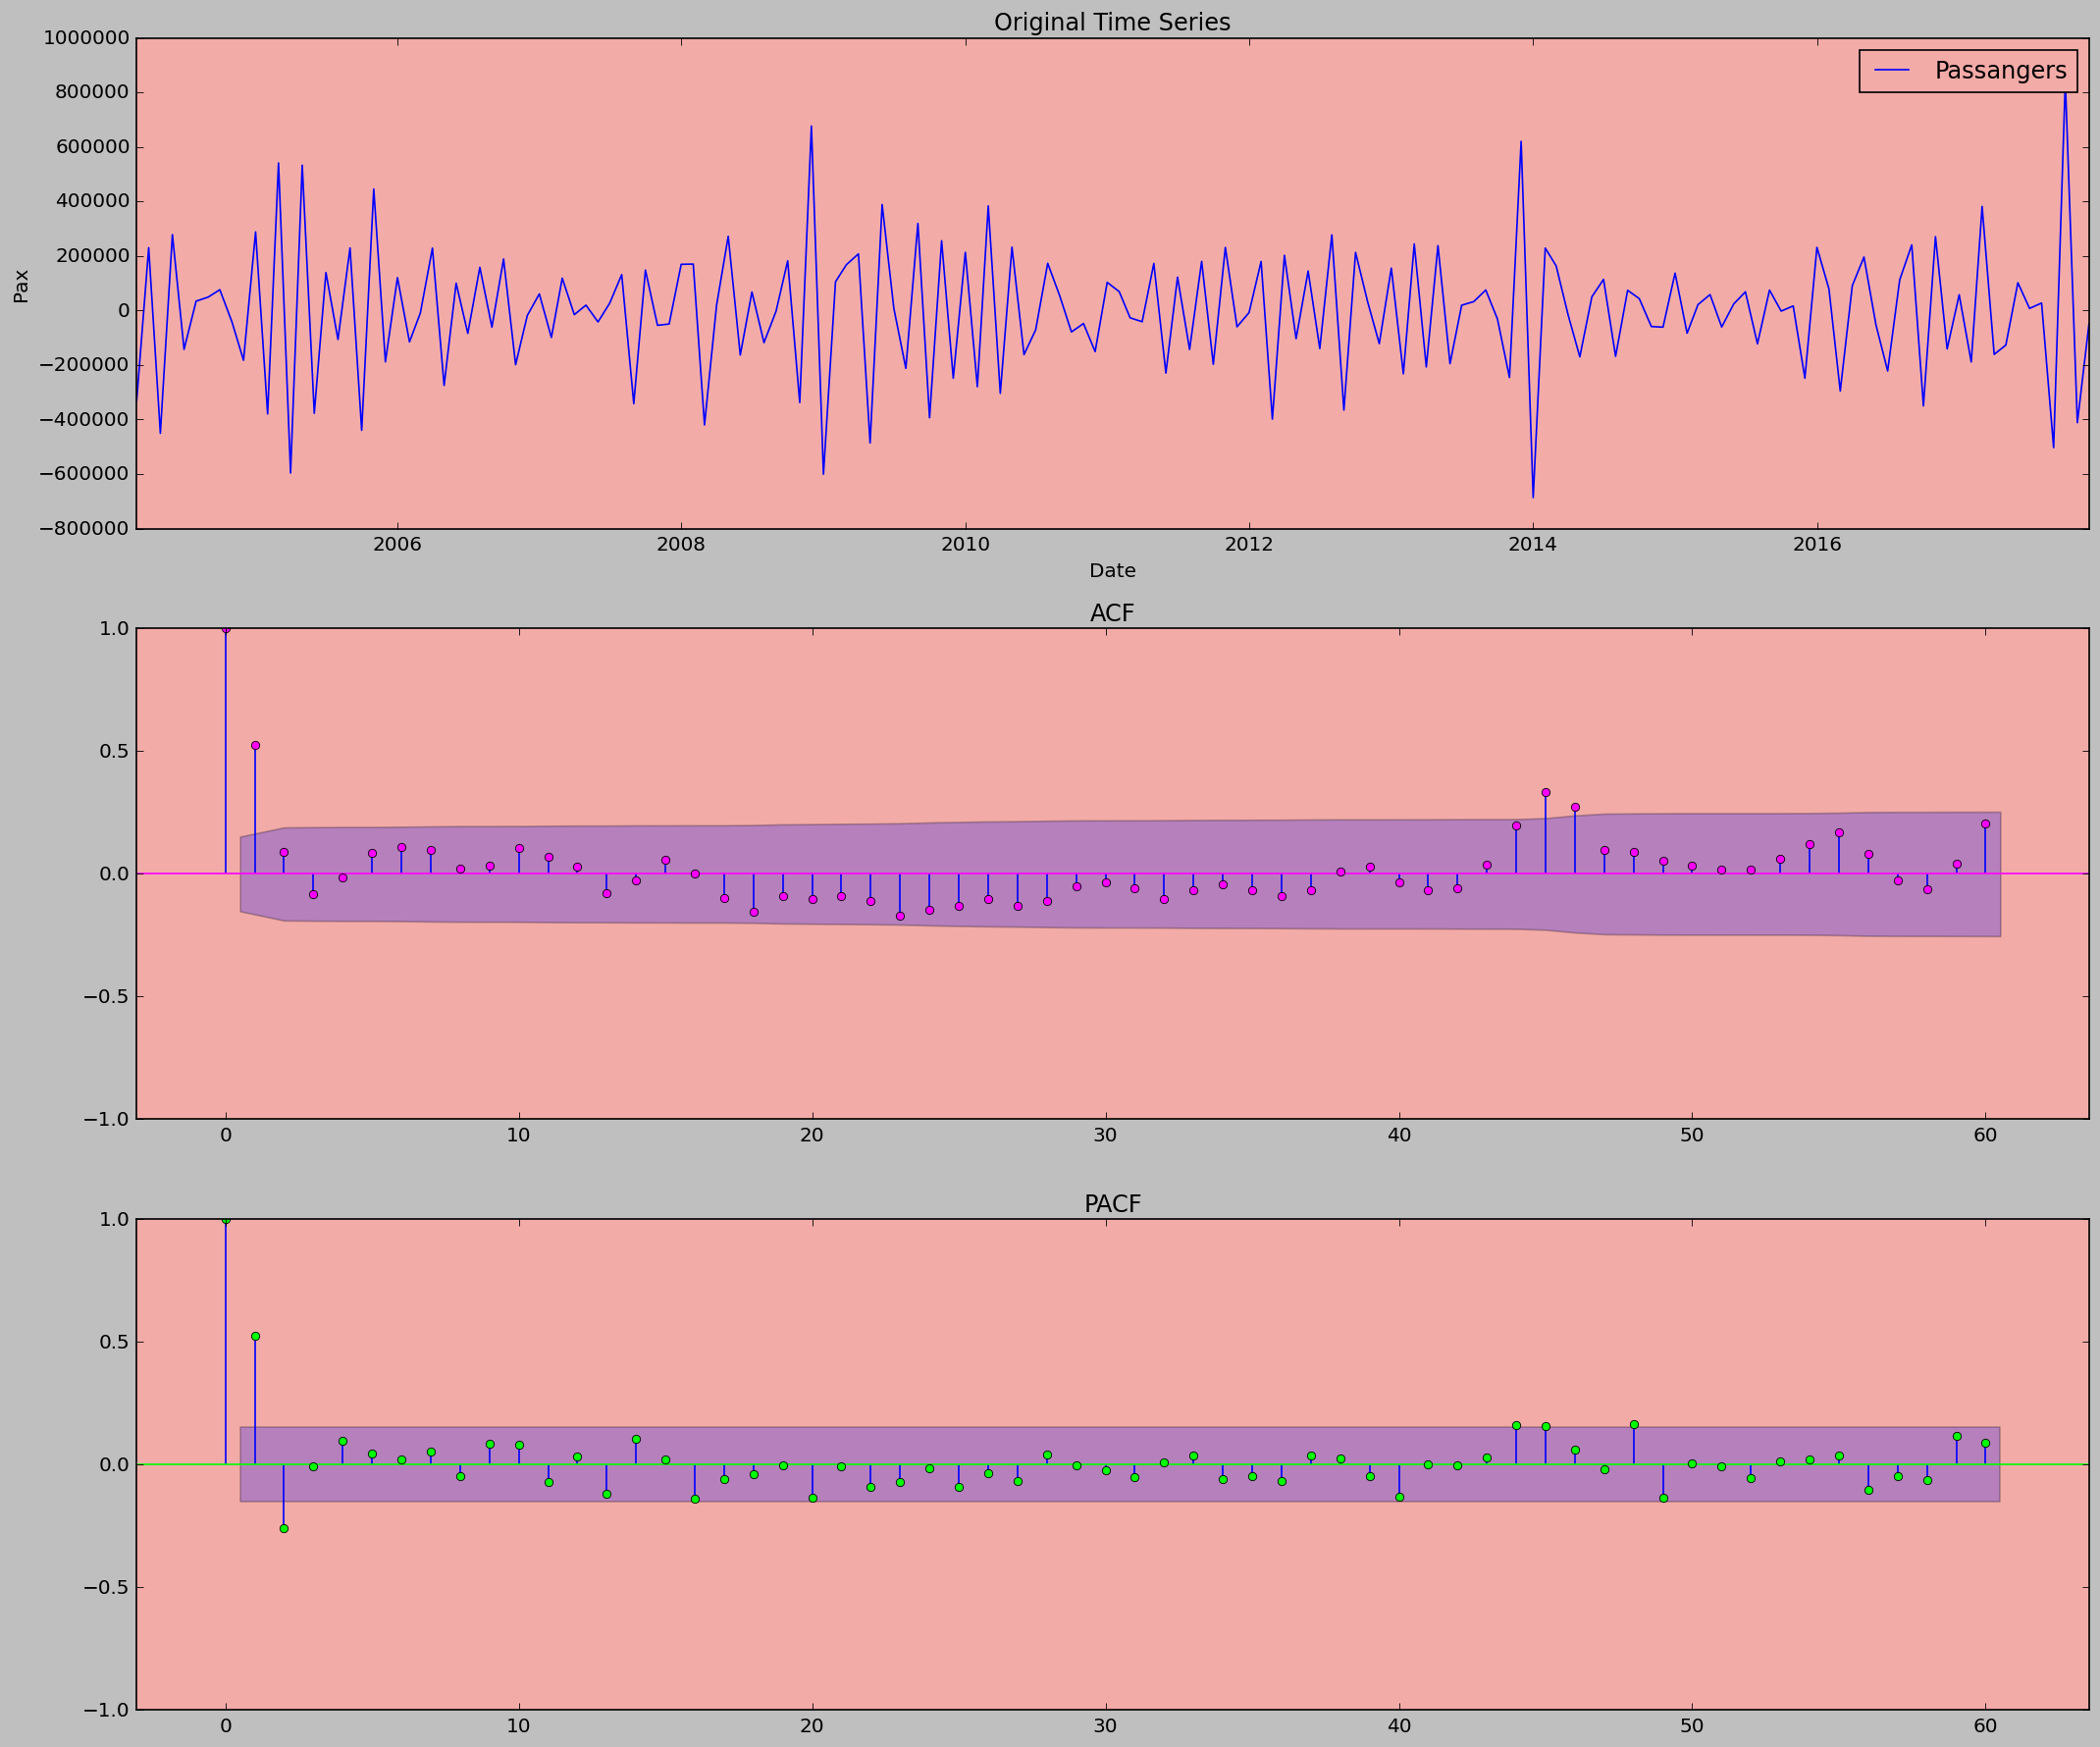

In [25]:
plt.rcParams.update({'figure.figsize': (18, 15), 'figure.dpi': 120})
fig, axs = plt.subplots(nrows=3, ncols=1)

sns.lineplot(data=W2, x='Date', y='Pax', label='Passangers', ax=axs[0]).set_title('Original Time Series')

plot_acf(np.abs(W2['Pax']), lags=60, color='fuchsia', ax=axs[1])
axs[1].set_title('ACF')

plot_pacf(np.abs(W2['Pax']), lags=60, color='lime', ax=axs[2])
axs[2].set_title('PACF')

plt.tight_layout() 
plt.show()


1. **p** (AR order - Autoregressive): it can be estimated from the PACF. Find the first cut (significant peak) on the PACF graph. The number of lags up to which the PACF cuts off (becomes non-significant) is the value of p. $$p=1$$

2. **q** (MA order - Moving average): it can be estimated from the ACF. Find the first cut (significant peak) on the ACF graph. The number of lags up to which the ACF cuts off (becomes non-significant) is the value of q. $$q=1$$

3. **P** (seasonal AR): it can be estimated from the seasonal PACF. In the case of a SARIMA model, the PACF is analyzed at multiple lags of the seasonality (for example, if the seasonality is 12 periods, the PACF is observed at lags 12, 24, 36, etc.). The first significant cut in these delays is the value of P. $$P=1$$

4. **Q** (seasonal MA): similar to the P value, it can be estimated from the seasonal ACF. Look at the seasonal delays (multiplied by seasonality, such as 12, 24, 36, etc.) and look for the first significant break in these delays. That is the value of Q. $$Q=1$$

<a id='sel'></a>
## 4. MODEL SELECTION

$$ARIMA(P,D,Q)_s × (p,d,q)$$



We use the AIC, AICc and BIC criteria to select the model that best suit our data:

* AIC: measure of the relative quality of a model that combines goodness of fit and model complexity. It is used to select the model that best fits the data with the fewest number of parameter. This measure is calculated as $𝐴𝐼𝐶 = 2𝑛𝑝 −2log(𝐿)$

* AICc: corrected version of the AIC that considers sample size. This measure is calculated 
as $AICc = \frac{2∙N∙np}{N−𝑛𝑝−1}−2log(𝐿)$

* BIC: measure of the relative quality of a model that combines goodness of fit and model complexity using a Bayesian approach. It is used to select the model that best fits the data with an additional penalty for complexity,favoring simpler models compared to the AIC. This measure is calculated as $𝐵𝐼𝐶 = 𝑛𝑝∙log(𝑁) − 2log(𝐿)$

In [26]:
D = 1
d = 2

p_values = [0, 1]
q_values = [0, 1]
P_values = [0, 1]
Q_values = [0, 1]

results = []

for p in p_values:
    for q in q_values:
        for Q in Q_values:
            for P in P_values:
                try:
                
                    model = ARIMA(X, order=(p, d, q), seasonal_order=(P, D, Q, 12)) 
                    model_fit = model.fit()

                    aic = model_fit.aic
                    bic = model_fit.bic

                    n = len(X)
                    aicc = aic + (2 * (p + q + 1) * (p + q + 2)) / (n - p - q - 2)  

                    results.append({
                        'p': p,
                        'q': q,
                        'P': P,
                        'Q': Q,
                        'AIC': aic,
                        'AICc': aicc,
                        'BIC': bic
                    })
                except Exception as e:
                    print(f"Error fitting ARIMA({p},{d},{q}) model: {e}")

if results:
    
    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by=['AIC', 'AICc', 'BIC'])
    top_4_models = results_df_sorted.head(4)
    print(top_4_models)
else:
    print("No valid models were found.")

    p  q  P  Q          AIC         AICc          BIC
12  1  1  0  0  4354.258500  4354.394864  4363.594464
15  1  1  1  1  4355.832738  4355.969101  4371.392677
14  1  1  0  1  4355.957786  4356.094149  4368.405737
13  1  1  1  0  4355.972381  4356.108744  4368.420332


According to the AIC, AICc and BIC criteria, the top 4 models are: 

1. $ARIMA(0,1,0)_{12} × (1,2,1)$
2. $ARIMA(1,1,1)_{12} × (1,2,1)$
3. $ARIMA(0,1,1)_{12} × (1,2,1)$
4. $ARIMA(1,1,0)_{12} × (1,2,1)$

In [27]:
#This helps us to choose the best model

# Fit the model with AIC
model_aic = auto_arima(train['Pax'].values, start_p=0, start_q=0,
                       test='adf',
                       max_p=1, max_q=1, 
                       d=2,
                       m=12,
                       seasonal=True,
                       start_P=0,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=False,
                       information_criterion='aic')

 ARIMA(0,2,0)(0,1,0)[12]             : AIC=5400.990, Time=0.03 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=5384.482, Time=0.28 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=5379.774, Time=1.23 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=5387.941, Time=0.30 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=5379.102, Time=0.57 sec
 ARIMA(0,2,0)(1,1,2)[12]             : AIC=5383.733, Time=1.32 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=5387.358, Time=0.52 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=5382.745, Time=0.97 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AIC=5389.486, Time=2.68 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(0,2,1)(2,1,0)[12] 

In [28]:
# Fit the model with AICc
model_aicc = auto_arima(train['Pax'].values, start_p=0, start_q=0,
                        test='adf',
                        max_p=1, max_q=1, 
                        d=2,
                        m=12,
                        seasonal=True,
                        start_P=0,
                        D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False,
                        information_criterion='aicc')

 ARIMA(0,2,0)(0,1,0)[12]             : AICC=5401.013, Time=0.04 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AICC=5384.549, Time=0.32 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AICC=5379.911, Time=1.48 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AICC=5388.009, Time=0.24 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AICC=5379.238, Time=0.59 sec
 ARIMA(0,2,0)(1,1,2)[12]             : AICC=5383.961, Time=1.54 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AICC=5387.494, Time=0.44 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AICC=5382.973, Time=1.08 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AICC=5389.831, Time=2.87 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AICC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AICC=inf, Time=0.68 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AICC=inf, Time=1.84 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AICC=inf, Time=0.77 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AICC=inf, Time=1.17 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AICC=inf, Time=2.79 sec
 ARIMA(0,2

In [29]:
# Fit the model with BIC
model_bic = auto_arima(train['Pax'].values, start_p=0, start_q=0,
                       test='adf',
                       max_p=1, max_q=1, 
                       d=2,
                       m=12,
                       seasonal=True,
                       start_P=0,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=False,
                       information_criterion='bic')

 ARIMA(0,2,0)(0,1,0)[12]             : BIC=5404.102, Time=0.04 sec
 ARIMA(0,2,0)(0,1,1)[12]             : BIC=5390.705, Time=0.31 sec
 ARIMA(0,2,0)(0,1,2)[12]             : BIC=5389.110, Time=1.48 sec
 ARIMA(0,2,0)(1,1,0)[12]             : BIC=5394.165, Time=0.19 sec
 ARIMA(0,2,0)(1,1,1)[12]             : BIC=5388.438, Time=0.58 sec
 ARIMA(0,2,0)(1,1,2)[12]             : BIC=5396.181, Time=1.61 sec
 ARIMA(0,2,0)(2,1,0)[12]             : BIC=5396.694, Time=0.43 sec
 ARIMA(0,2,0)(2,1,1)[12]             : BIC=5395.193, Time=1.11 sec
 ARIMA(0,2,0)(2,1,2)[12]             : BIC=5405.046, Time=3.03 sec
 ARIMA(0,2,1)(0,1,0)[12]             : BIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,1,1)[12]             : BIC=inf, Time=0.71 sec
 ARIMA(0,2,1)(0,1,2)[12]             : BIC=inf, Time=1.97 sec
 ARIMA(0,2,1)(1,1,0)[12]             : BIC=inf, Time=0.75 sec
 ARIMA(0,2,1)(1,1,1)[12]             : BIC=inf, Time=1.09 sec
 ARIMA(0,2,1)(1,1,2)[12]             : BIC=inf, Time=2.55 sec
 ARIMA(0,2,1)(2,1,0)[12] 

In [30]:
print("Modelo con AIC:")
print(model_aic.summary())

Modelo con AIC:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -2579.080
Date:                            Tue, 11 Feb 2025   AIC                           5168.160
Time:                                    19:24:22   BIC                           5183.720
Sample:                                         0   HQIC                          5174.476
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5004      0.068     -7.355      0.000      -0.634      -0.367
ma.L1         -0.98

In [31]:
print("Modelo con AICc:")
print(model_aicc.summary())

Modelo con AICc:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -2579.080
Date:                            Tue, 11 Feb 2025   AIC                           5168.160
Time:                                    19:24:22   BIC                           5183.720
Sample:                                         0   HQIC                          5174.476
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5004      0.068     -7.355      0.000      -0.634      -0.367
ma.L1         -0.9

In [32]:
print("Modelo con BIC:")
print(model_bic.summary())

Modelo con BIC:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -2579.080
Date:                            Tue, 11 Feb 2025   AIC                           5168.160
Time:                                    19:24:22   BIC                           5183.720
Sample:                                         0   HQIC                          5174.476
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5004      0.068     -7.355      0.000      -0.634      -0.367
ma.L1         -0.98

For the 3 criteria, the best model is: 
$$ARIMA(1,1,1)_{12}×(1,2,1)$$


In [33]:
model_auto_sarima = auto_arima(train['Pax'].values, start_p=0, start_q=0,
                        test='adf',
                        max_p=1, max_q=1, 
                        d=2,
                        m=12,
                        seasonal=True,
                        start_P=0,
                        D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False) 

print(model_auto_sarima.summary())

 ARIMA(0,2,0)(0,1,0)[12]             : AIC=5400.990, Time=0.04 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=5384.482, Time=0.28 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=5379.774, Time=1.17 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=5387.941, Time=0.21 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=5379.102, Time=0.61 sec
 ARIMA(0,2,0)(1,1,2)[12]             : AIC=5383.733, Time=1.31 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=5387.358, Time=0.61 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=5382.745, Time=0.90 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AIC=5389.486, Time=2.30 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,2,1)(2,1,0)[12] 

<function matplotlib.pyplot.show(close=None, block=None)>

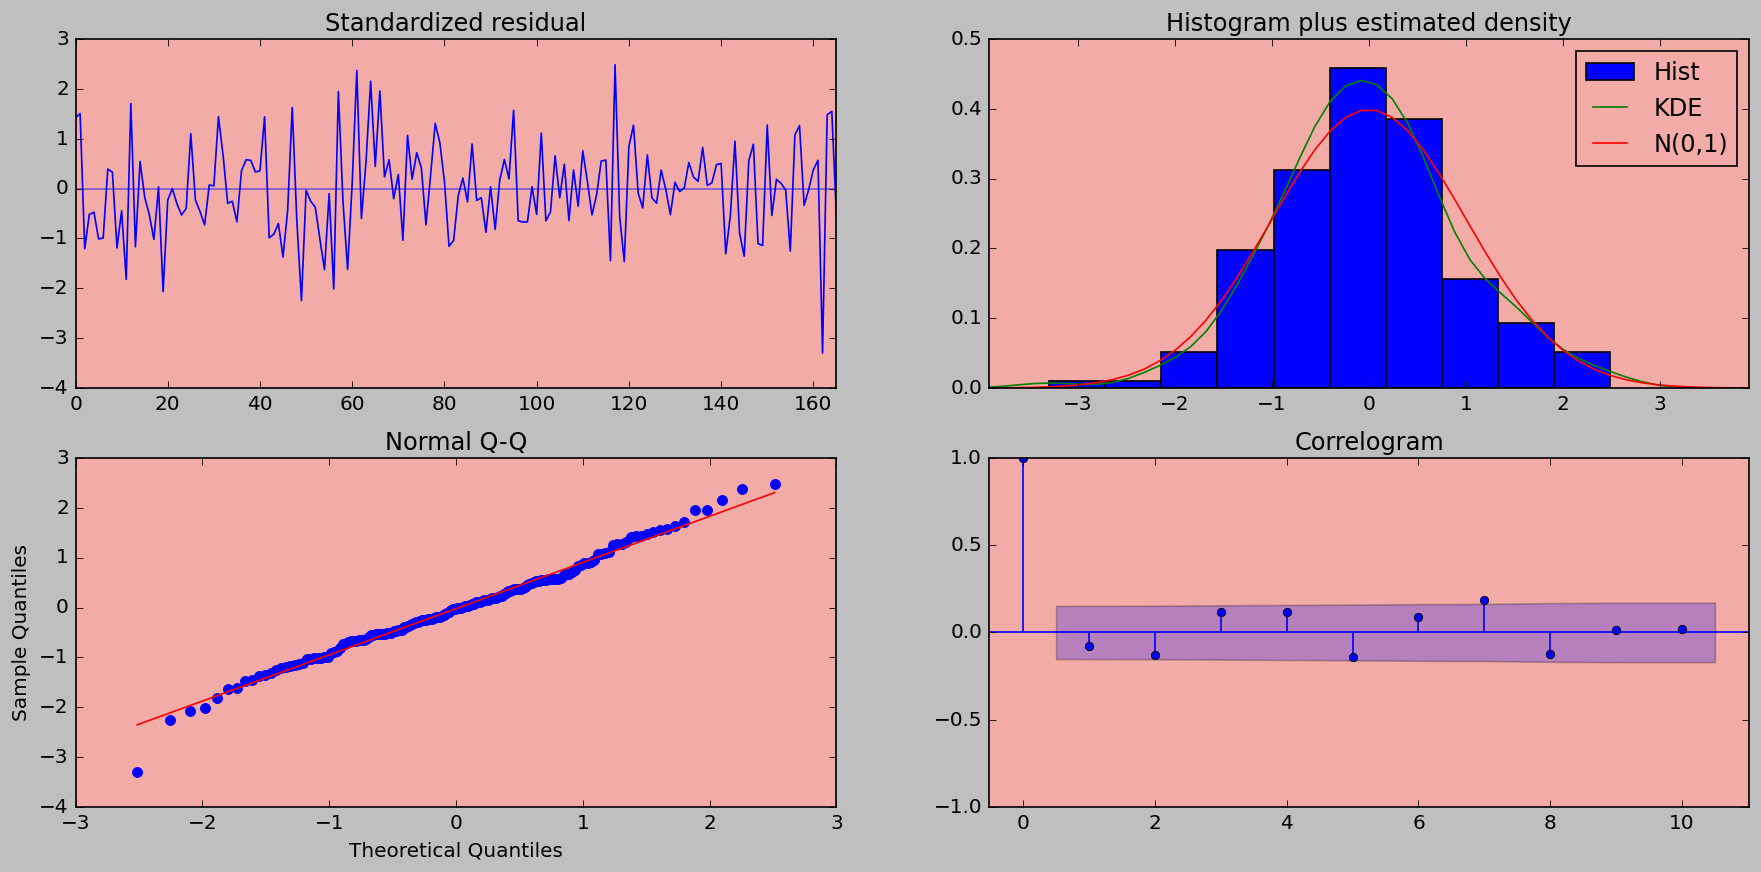

In [34]:
model_auto_sarima.plot_diagnostics(figsize=(18,8))
plt.show

<a id='fit'></a>
## 5. MODEL FIT AND PREDICTION. FINAL ERRORS TEST

We  obtain predictions with a 95% confidence interval

In [35]:
forecast_auto_sarima = model_auto_sarima.predict(n_periods = 24, return_conf_int=True)
forecast_values = forecast_auto_sarima[0]
confidence_int = forecast_auto_sarima[1]

In [36]:
y_auto_sarima = pd.DataFrame(forecast_auto_sarima[1], columns = (['low','high']))
y_auto_sarima['pred'] = forecast_auto_sarima[0]
y_auto_sarima['fecha'] = pd.date_range(start = '2018-01-01', periods=24, freq='MS')
y_auto_sarima = y_auto_sarima.set_index('fecha')
y_auto_sarima

,low,high,pred
fecha,,,
2018-01-01,6.251144e+07,6.817643e+07,6.534393e+07
2018-02-01,5.783566e+07,6.419915e+07,6.101740e+07
2018-03-01,7.172370e+07,7.943254e+07,7.557812e+07
2018-04-01,6.854940e+07,7.709693e+07,7.282317e+07
2018-05-01,7.152317e+07,8.099891e+07,7.626104e+07
2018-06-01,7.441569e+07,8.468527e+07,7.955048e+07
2018-07-01,7.686036e+07,8.791542e+07,8.238789e+07
2018-08-01,7.378870e+07,8.557740e+07,7.968305e+07
2018-09-01,6.146994e+07,7.397145e+07,6.772069e+07


In [37]:
plt.style.use('classic')
dark_style={
    'axes.facecolor':'#d3c3f7'}
plt.rcParams.update(dark_style)

Plot of the prediction of 24 steps ahead

<function matplotlib.pyplot.show(close=None, block=None)>

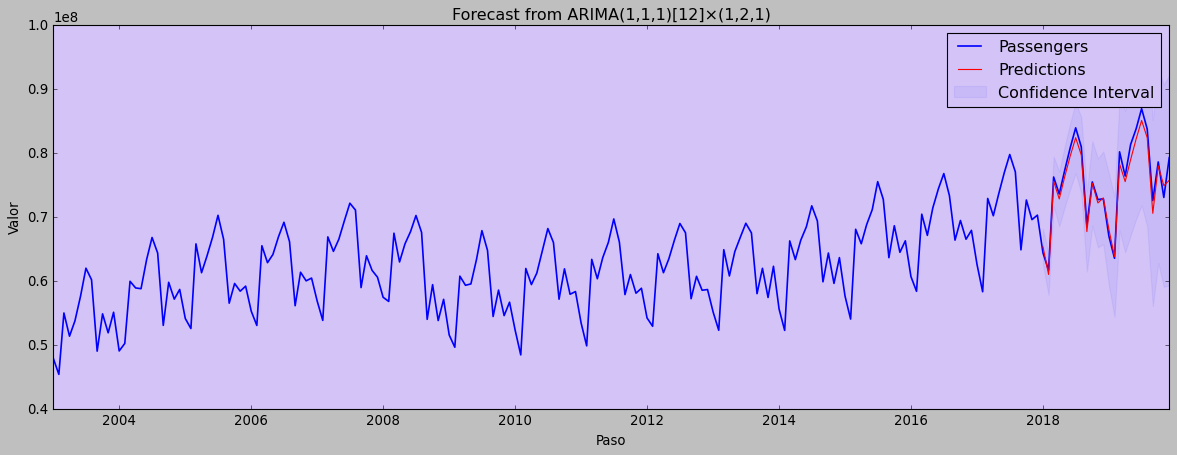

In [38]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df1, x=df1['Date'], y=df1['Pax'], label = 'Passengers', linewidth=1.5)
plt.plot(y_auto_sarima['pred'], label = 'Predictions', color = 'red')
plt.fill_between(y_auto_sarima.index, y_auto_sarima['low'], y_auto_sarima['high'], color='b', alpha=0.05, label='Confidence Interval')
plt.xlabel('Paso')
plt.ylabel('Valor')
plt.title('Forecast from ARIMA(1,1,1)[12]×(1,2,1)')
plt.legend()
plt.show

Finally, we evaluate the model by using the following metrics.

In [39]:
def EVAL_METRICS_FUNC(y_true, y_pred):
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Metric evaluation result:-')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {MAPE(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [40]:
EVAL_METRICS_FUNC(test['Pax'], y_auto_sarima['pred'])

Metric evaluation result:-
MSE: 2060927513358.509
MAE: 1215279.172692523
RMSE: 1435593.0876674312
MAPE: 1.5765311315076054
R2: 0.9546308294684757

